In [1]:
import pickle
import sys
from tqdm import tqdm
import numpy as np
sys.path.insert(1, '../..')
import eval
import numpy as np
import random

In [ ]:
DATASET = "concept_properties" # "feature_norms", "memory_colors"

In [2]:
noun2prop = pickle.load(open(f"../data/datasets/{DATASET}/noun2property/noun2prop.p", "rb"))
gpt3_predicts = pickle.load(open(f"../data/datasets/{DATASET}/GPT3/gpt3_predicts.txt", "rb"))
roberta_predicts = pickle.load(open(f"../output/output_{DATASET}/roberta-large+singular_generally.p", "rb"))
bert_predicts = pickle.load(open(f"../output/output_{DATASET}/bert-large-uncased+plural_most.p", "rb"))
clip_predicts = pickle.load(open(f"../data/datasets/{DATASET}/CLIP/clip_scores.p", "rb"))
combined_predicts = pickle.load(open(f"../data/datasets/{DATASET}/CEM/combine_scores.p", "rb"))
gpt_predicts = pickle.load(open(f"../output/output_{DATASET}/gpt2-large+plural_most.p", "rb"))
candidate_adjs = []
for noun, props in noun2prop.items():
    candidate_adjs += props
candidate_adjs = list(set(candidate_adjs))

from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
concreteness = {w: c / 5 for w, c in pickle.load(open("../data/concreteness/word2concreteness.M.p", "rb")).items()}
all_words = list(concreteness.keys())
prop2concretness = {}
for prop in tqdm(candidate_adjs):
    if prop in concreteness:
        prop2concretness[prop] = concreteness[prop]
    else:
        sims = []
        for word in all_words:
            sims.append((word, similar(word, prop)))
        sims.sort(key=lambda x: x[1], reverse=True)
        prop2concretness[prop] = concreteness[sims[0][0]]

100%|██████████| 400/400 [00:37<00:00, 10.80it/s]


In [3]:
noun2prop_most_concrete = {}
noun2prop_least_concrete = {}
noun2prop_random_concrete = {}
for noun, props in noun2prop.items():
    prop_w_concretness = [(prop, prop2concretness[prop]) for prop in props]
    prop_w_concretness.sort(key=lambda x: x[1])
    noun2prop_most_concrete[noun] = [prop_w_concretness[-1][0]]
    noun2prop_least_concrete[noun] = [prop_w_concretness[0][0]]
    noun2prop_random_concrete[noun] = [random.choice(props)]
# noun2prop_random_concrete = pickle.load(open("noun2prop_random_concrete.p", "rb"))

In [6]:
for noun2prop_test in [noun2prop_most_concrete, noun2prop_least_concrete, noun2prop_random_concrete]:
    noun2predicts = bert_predicts
    for k in [1]:
        eval.evaluate_acc(noun2predicts, noun2prop_test, k, True)

# for k in [1, 5, 10]:
#     eval.evaluate_precision(noun2predicts, noun2prop_test, k, True)

# for k in [1, 5, 10]:
#     eval.evaluate_recall(noun2predicts, noun2prop_test, k, True)

top1 acc:  0.04492512479201331
top1 acc:  0.02329450915141431
top1 acc:  0.04159733777038269


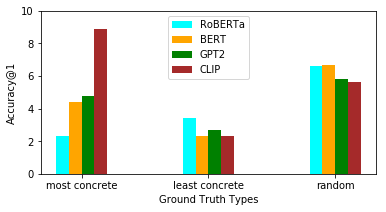

In [64]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (6,3)
# create data
x = 2 * np.arange(3)
y1 = [2.3, 3.5, 6.6]
y2 = [4.4, 2.3, 6.7]
y3 = [4.8, 2.7, 5.8]
y4 = [8.9, 2.3, 5.6]
width = 0.2

plt.ylim((0, 10))  
# plot data in grouped manner of bar type
plt.bar(x-0.3, y1, width, color='cyan')
plt.bar(x-0.1, y2, width, color='orange')
plt.bar(x+0.1, y3, width, color='green')
plt.bar(x+0.3, y4, width, color='brown')
# plt.bar(x+0.4, y3, width, color='green')
plt.xticks(x, ["most concrete", "least concrete", "random"])
plt.xlabel("Ground Truth Types")
plt.ylabel("Accuracy@1")
plt.legend(["RoBERTa", "BERT", "GPT2", "CLIP"])
plt.savefig('distribution.png', format='png', dpi=600, bbox_inches='tight')
plt.show()